In [67]:
import torch 
from torchvision import transforms , datasets
from torch.utils.data import DataLoader

In [68]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

In [69]:
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),
#     transforms.Resize((48,48)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5] ,std=[0.5])
# ])

In [70]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # normalize
])


In [71]:
train_path = "C:/Users/sanju/OneDrive/Desktop/EmotionDetection/data/train"
test_path = "C:/Users/sanju/OneDrive/Desktop/EmotionDetection/data/test"

In [72]:
train_dataset = datasets.ImageFolder(train_path, transform=transform) 
test_dataset = datasets.ImageFolder(test_path , transform=transform) 

In [73]:
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=32 , shuffle=False)

In [74]:
train_dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [75]:
train_dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.20784318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


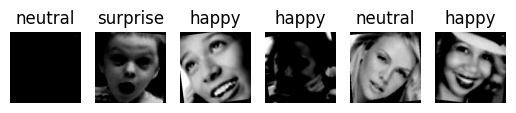

In [76]:
import matplotlib.pyplot as plt 

images , labels = next(iter(train_loader))

# fig , axes = plt.subplot()

for i in range(6):
    img = images[i].permute(1,2,0).numpy()
    plt.subplot(1,6,i+1)
    plt.imshow(img , cmap="gray")
    plt.title(train_dataset.classes[labels[i]])
    plt.axis(False)
plt.show()

In [77]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # print(x.shape)
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.classifier(x)
        return x


In [78]:
# (32x50176 and 2304x512)
256*14*14

50176

In [79]:
# 32x2304 and 9216x512
256*3*3

2304

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [81]:
# def train_model(model, loader, criterion, optimizer, epochs=10):
#     model.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         correct, total = 0, 0

#         for images, labels in loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()

#         print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f} | Acc: {100*correct/total:.2f}%")


In [82]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        # -----------------
        # Training Phase
        # -----------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # -----------------
        # Evaluation Phase
        # -----------------
        model.eval()
        test_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100 * correct / total

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"| Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


In [83]:
train_model(model, train_loader,test_loader , criterion, optimizer, epochs=5)


Epoch 1/5 | Train Loss: 1.7199, Train Acc: 30.50% | Test Loss: 1.5672, Test Acc: 38.49%
Epoch 2/5 | Train Loss: 1.5076, Train Acc: 41.23% | Test Loss: 1.3999, Test Acc: 45.88%
Epoch 3/5 | Train Loss: 1.3799, Train Acc: 46.63% | Test Loss: 1.3104, Test Acc: 49.67%
Epoch 4/5 | Train Loss: 1.3071, Train Acc: 49.56% | Test Loss: 1.2657, Test Acc: 50.74%
Epoch 5/5 | Train Loss: 1.2657, Train Acc: 51.44% | Test Loss: 1.2265, Test Acc: 53.02%


In [84]:
from pathlib import Path
model_save_path = "C:/Users/sanju/OneDrive/Desktop/EmotionDetection/model"
torch.save(model.state_dict(), Path(model_save_path,"BaselineCNN.pth"))

In [85]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet
ResNet18_model = models.resnet18(pretrained=True)

# Modify input layer (for 1-channel grayscale → 3-channel workaround)
ResNet18_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace final layer
num_features = ResNet18_model.fc.in_features
ResNet18_model.fc = nn.Linear(num_features, 7)  # 7 emotions

# Freeze earlier layers (transfer learning)
for param in ResNet18_model.parameters():
    param.requires_grad = False
for param in ResNet18_model.fc.parameters():
    param.requires_grad = True


c:\Users\sanju\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sanju\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [87]:
optimizer = torch.optim.Adam(ResNet18_model.fc.parameters(), lr=1e-4, weight_decay=1e-5)

In [88]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract all labels from your dataset
train_labels = [label for _, label in train_dataset]  # if train_dataset is a torchvision dataset

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to tensor for PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use in loss
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
train_model(ResNet18_model, train_loader,test_loader, criterion, optimizer, epochs=10)

KeyboardInterrupt: 

In [ ]:
from pathlib import Path
model_save_path = "C:/Users/sanju/OneDrive/Desktop/EmotionDetection/model"
torch.save(ResNet18_model.state_dict(), Path(model_save_path,"ResNet18.pth"))

In [92]:
ResNet50_model = models.resnet50(pretrained=True)

# Freeze early layers
for param in ResNet50_model.parameters():
    param.requires_grad = False

# Replace last layer
num_features = ResNet50_model.fc.in_features
ResNet50_model.fc = nn.Linear(num_features, 7)  # 7 emotion classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ResNet50_model = ResNet50_model.to(device)

# --------------------------
# Compute Class Weights
# --------------------------
train_labels = [label for _, label in train_dataset]  # get all labels from dataset
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# --------------------------
# Step 1: Freeze all except final layer
# --------------------------
for param in ResNet50_model.parameters():
    param.requires_grad = False
for param in ResNet50_model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(ResNet50_model.fc.parameters(), lr=1e-3)


c:\Users\sanju\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sanju\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_model(ResNet50_model, train_loader,test_loader, criterion, optimizer, epochs=10)

In [ ]:
# Step 3: Unfreeze Last Block (layer4)
# --------------------------
for name, param in ResNet50_model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

optimizer = optim.Adam([
    {"params": ResNet50_model.fc.parameters(), "lr": 1e-3},
    {"params": ResNet50_model.layer4.parameters(), "lr": 1e-5}
])

print("🔹 Fine-tuning layer4...")
train_model(ResNet50_model, train_loader, test_loader, criterion, optimizer, epochs=10)


In [ ]:
# --------------------------
# Step 4 (Optional): Unfreeze layer3 as well
# --------------------------
for name, param in ResNet50_model.named_parameters():
    if "layer3" in name:
        param.requires_grad = True

optimizer = optim.Adam([
    {"params": ResNet50_model.fc.parameters(), "lr": 1e-3},
    {"params": ResNet50_model.layer4.parameters(), "lr": 1e-5},
    {"params": ResNet50_model.layer3.parameters(), "lr": 1e-5}
])

print("🔹 Fine-tuning layer3 + layer4...")
train_model(ResNet50_model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10 | Loss: 1.9654 | Acc: 16.17%
Epoch 2/10 | Loss: 1.9659 | Acc: 16.32%
Epoch 3/10 | Loss: 1.9661 | Acc: 16.23%
Epoch 4/10 | Loss: 1.9638 | Acc: 16.92%
Epoch 5/10 | Loss: 1.9662 | Acc: 16.63%
Epoch 6/10 | Loss: 1.9638 | Acc: 16.74%
Epoch 7/10 | Loss: 1.9674 | Acc: 16.60%
Epoch 8/10 | Loss: 1.9645 | Acc: 16.61%
Epoch 9/10 | Loss: 1.9655 | Acc: 16.31%
Epoch 10/10 | Loss: 1.9651 | Acc: 16.61%


In [ ]:
from pathlib import Path
model_save_path = "C:/Users/sanju/OneDrive/Desktop/EmotionDetection/model"
torch.save(ResNet50_model.state_dict(), Path(model_save_path,"ResNet50.pth"))